In [1]:
#imports for image reading
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import albumentations as alb

#imports for models
import tensorflow as tf

#extra imports
import time
import uuid
import os
import json
import traceback

In [2]:
CURRENT_PATH = os.getcwd()

IMAGE_PATH = os.path.join(os.getcwd(), 'data', 'images')
LABEL_PATH = os.path.join(os.getcwd(), 'data', 'labels')

TRAIN_PATH = os.path.join(os.getcwd(), "data", "train")
TEST_PATH = os.path.join(os.getcwd(), "data", "test")
VAL_PATH = os.path.join(os.getcwd(), "data", "val")

##  Capturing Raw Data

In [ ]:
### capturing images through the cameras
cap = cv2.VideoCapture(0)
total_images = 30

os.chdir(IMAGE_PATH)

for i in range(total_images):
    print(f"Collecting Image number: {i}")
    ret, frame = cap.read()
    image_name = f"{str(uuid.uuid1())}.jpg"
    cv2.imwrite(image_name, frame)
    cv2.imshow("image_frame", frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## Labelling the Image 

In [ ]:
!labelme

## Spliting Data into train, test and val

In [ ]:
#bringing the dataset
DATA_PATH = IMAGE_PATH+"\\*.jpg"
data = tf.data.Dataset.list_files(DATA_PATH, shuffle=True)

In [ ]:
#to check if the dataset read worked - file path to an images should come as output
data.as_numpy_iterator().next()

In [ ]:
#function to get images from the files read
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)
    return img

In [ ]:
#map the function to the data path to get all the images

images = data.map(load_images)

# images.as_numpy_iterator().next()

In [ ]:
#Visualising the images

batch_image = images.batch(batch_size=4).as_numpy_iterator()
plot_img = batch_image.next()

In [ ]:
fig, ax = plt.subplots(ncols=4)
for index, image in enumerate(plot_img):
    ax[index].imshow(image)
plt.show()

In [ ]:
os.getcwd()

In [ ]:
# getting the lables to the image

for i in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join(os.getcwd(), 'data', i, 'images')):
        file_name = file.split('.')[0] + ".json"
        existing_label = os.path.join(os.getcwd(), 'data', 'labels', file_name)
        if os.path.exists(existing_label):
            new_label = os.path.join(os.getcwd(), 'data', i, 'labels', file_name)
            os.replace(existing_label, new_label)

## Augment the Data

###  Creating the Augmenting pipeline

### Reading an Image

In [3]:
img = plt.imread("E:\\Github\\Deep-Learning\\VideoTagger[WIP]\\data\\train\\images\\ba9e69ba-2f03-11ee-b7e9-d8bbc1768911.jpg")
# plt.imshow(img)

### Reading Labels of the image

In [8]:
with open(os.path.join(TRAIN_PATH, "labels", "ba9e69ba-2f03-11ee-b7e9-d8bbc1768911.json"), 'r') as f:
    label = json.load(f)
# label

### Filtering out Boundary box coordinate

In [9]:
coords = [0,0,0,0]

coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

ordinate = np.array(coords)
ordinate = ordinate.astype(int)
# coords

In [119]:
rect_face = cv2.rectangle(img, (ordinate[:2]), (ordinate[2:]), [255, 0, 0], 2)
# plt.imshow(rect_face)

In [12]:
album_coords = np.divide(coords, [640, 480, 640, 480]).astype(int)
album_coords

array([0, 0, 0, 0])

### Running the Image and Corrected Coordinates through Albumentation pipe

In [120]:
mod_img = augmentor(image=img, bboxes=[album_coords], class_labels=["face"])
# plt.imshow(mod_img[])
# mod_img['bboxes'][0][2:]

In [112]:
new_img = cv2.rectangle(mod_img['image'], (np.multiply(mod_img['bboxes'][0][:2], [450, 450]).astype(int)), 
                        (np.multiply(mod_img['bboxes'][0][2:], [450,450]).astype(int)),
                       (0,255,0), 5)


# cv2.imwrite("cv_img.jpeg", mod_img['image'])

True

### Fetching New Coords

In [122]:
label_img = { 'points': mod_img['bboxes'],
             'class': mod_img['class_labels']}

4

### Summing all Together

In [14]:
augmentor = alb.Compose(transforms=[alb.RandomCrop(width = 450, height = 450),
                                   alb.HorizontalFlip(p=0.5),
                                   alb.RandomBrightnessContrast(p=0.3),
                                   alb.RandomGamma(p=0.4),
                                   alb.RGBShift(p=0.3),
                                   alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams("albumentations", label_fields=["class_labels"]))

In [74]:
#going through each folder
for i in ["train", "test", "val"]:
    #going through each image in a folder
    for images in os.listdir(os.path.join(os.getcwd(), "data", i, "images")):
        img = cv2.imread(os.path.join(os.getcwd(), "data", i, "images", images))
        label_name = images.split('.')[0]+".json"
        label_path = os.path.join(os.getcwd(), "data", i, "labels", label_name)
        #check if corresponding label json exists - and setting coordinates
        if os.path.exists(label_path):
            with open(os.path.join(os.getcwd(), "data", i, "labels", label_name), 'r') as f:
                img_label = json.load(f)
                coords = [0,0,0,0]
                coords[0] = img_label['shapes'][0]['points'][0][0]
                coords[1] = img_label['shapes'][0]['points'][0][1]
                coords[2] = img_label['shapes'][0]['points'][1][0]
                coords[3] = img_label['shapes'][0]['points'][1][1]
            coords = np.divide(coords, [640, 480, 640, 480])
        else:
            coords = [0,0,0.001,0.001]
            
        #create 60 augmented images per raw image - and save in different folder augmented for train, test and val  
        try:
            for j in range(60):
                aug_img = augmentor(image = img, bboxes = [coords], class_labels = ["face"])
                cv2.imwrite(os.path.join(os.getcwd(), "augmented", i, "images", f"{images.split('.')[0]}_{j}.jpeg"), aug_img['image'])

                aug_label = {}
                aug_label['image'] = images
                
                if os.path.exists(label_path):
                    if len(aug_img['bboxes']) == 0:
                        aug_label['bboxes'] = [0,0,0,0]
                        aug_label['class'] = 0
                    else:
                        aug_label['bboxes'] = aug_img['bboxes'][0]
                        aug_label['class'] = 1
                else:
                    aug_label['bboxes'] = [0,0,0,0]
                    aug_label['class'] = 0
                
                with open(os.path.join(os.getcwd(), "augmented", i, "labels", f"{images.split('.')[0]}_{j}.json"), 'w') as f:
                    json.dump(aug_label,f)
        except:
            traceback.print_exc()
            

## Image Correction for Modelling

In [29]:
def get_images(file):
    img = tf.io.read_file(file)
    img = tf.io.decode_jpeg(img)

    return img

In [73]:
#train data prep

train_data = tf.data.Dataset.list_files("augmented\\train\\images\\*.jpeg")
train_images = train_data.map(get_images)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

#test data prep
test_data = tf.data.Dataset.list_files("augmented\\test\\images\\*.jpeg")
test_images = test_data.map(get_images)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

#val data prep
val_data = tf.data.Dataset.list_files("augmented\\val\\images\\*.jpeg")
val_images = val_data.map(get_images)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

## Label Preparation for Modelling

In [75]:
def read_label(path):
    with open(path.numpy(), 'r',encoding='utf-8') as f:
        label = json.load(f)
    return [label['class']], label['bboxes']

In [108]:
train_label_data = tf.data.Dataset.list_files("augmented\\train\\labels\\*.json")
train_label = train_label_data.map(lambda x: tf.py_function(read_label, [x], [tf.uint8, tf.float16]))

test_label_data = tf.data.Dataset.list_files("augmented\\test\\labels\\*.json")
test_label = test_label_data.map(lambda x: tf.py_function(read_label, [x], [tf.uint8, tf.float16]))

val_label_data = tf.data.Dataset.list_files("augmented\\val\\labels\\*.json")
val_label = val_label_data.map(lambda x: tf.py_function(read_label, [x], [tf.uint8, tf.float16]))

## Combining Image and Labels to create Dataset

In [138]:
train = tf.data.Dataset.zip((train_images, train_label))
train = train.shuffle(4000)
train = train.batch(10)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_label))
test = test.shuffle(4000)
test = test.batch(10)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_label))
val = val.shuffle(4000)
val = val.batch(10)
val = val.prefetch(4)

In [139]:
res = train.as_numpy_iterator().next() 

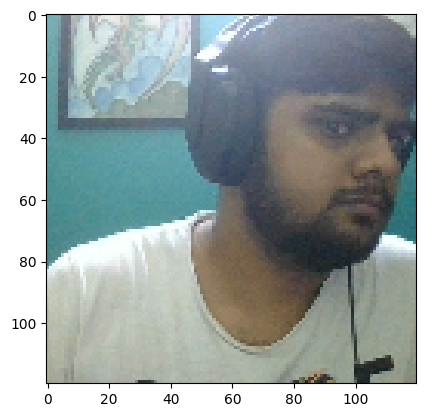

In [156]:
plt.imshow(res[0][6])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


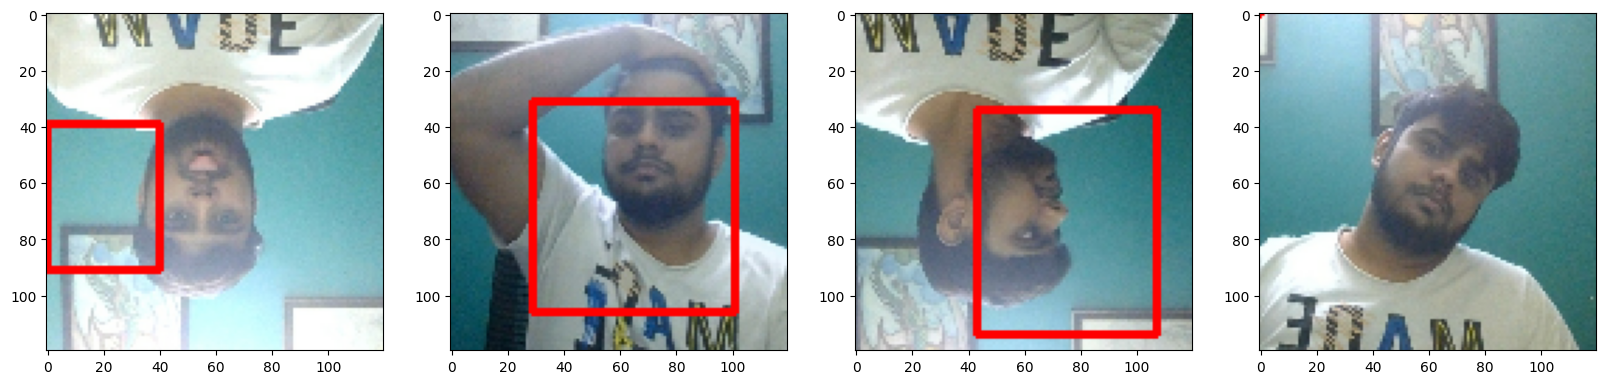

In [143]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)